Language Models!
================

What the heck!? The human race has been around for like 10000 - 1.5 million years and in all that time if you wanted to have a conversation with something you had only one choice: another person.

And yet it can be said that in the last 4 years that state of affairs has changed: you can now talk to something called a language model. This surprised me as it surprised many people.

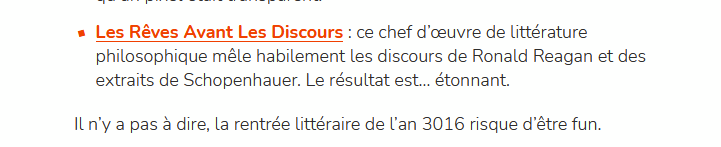

The above quote is coverage in a french media magazine of my very own pre-language model text-generation attempt as part of national novel generating month. I used something called a Markov model to perform this task and I want to explain how that works as a way of gently hinting at how language models work.

Let's begin with a corpus of words:

In [1]:
# Required libraries
import requests
import nltk
from nltk.tokenize import word_tokenize
from collections import defaultdict, Counter
import random

# Ensure necessary nltk packages are downloaded
nltk.download('punkt_tab')

# Step 1: Fetch text from URL
url = "https://www.gutenberg.org/cache/epub/10662/pg10662.txt"
response = requests.get(url)
text = response.text

# Step 2: Tokenize the text
tokens = word_tokenize(text.lower())

# Step 3: Build the Markov model (bigram-based)
markov_model = defaultdict(Counter)

for i in range(len(tokens) - 1):
    current_word = tokens[i]
    next_word = tokens[i + 1]
    markov_model[current_word][next_word] += 1

# Step 4: Function to predict the next word
def predict_next_word(word, model=markov_model):
    if word not in model:
        return None
    next_words = model[word]
    return random.choices(list(next_words.keys()), weights=list(next_words.values()))[0]

# Step 5: Example Usage
# To generate a sequence of words starting from a given word
def generate_text(start_word, length=10):
    word_sequence = [start_word]
    for _ in range(length - 1):
        next_word = predict_next_word(word_sequence[-1])
        if next_word is None:
            break
        word_sequence.append(next_word)
    return ' '.join(word_sequence)

# Example usage: Generate a sequence starting from "love"
print(generate_text("love", 45))


[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/rstudio/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


love , even when i knew it . and to come immediately , which took the light doth love , and laughed at the rock as the bushes and foolish , and she did not to think that i had gotten soiled and came running


In [2]:
!pip3 install nltk 

Defaulting to user installation because normal site-packages is not writeable


This sucks! 

Why? Well, we're only using one previous word to guess the next word and this doesn't even guarantee gramattically correct generation. Can we do better? One we is to use more words going back in the history of the generated text.

In [3]:
class NGramMarkovModel:
    def __init__(self, corpus=None, n=2):
        """
        Initialize the N-gram Markov Model with an optional initial corpus and an n-gram size.
        """
        self.n = n
        self.model = defaultdict(Counter)
        self.start_ngrams = []  # To store valid start n-grams
        
        # If an initial corpus is provided, digest it
        if corpus:
            self.digest_text(corpus)
    
    def _update_model(self, tokens):
        """
        Updates the model with tokens from a corpus.
        """
        for i in range(len(tokens) - self.n + 1):
            ngram = tuple(tokens[i:i + self.n - 1])
            next_word = tokens[i + self.n - 1]
            self.model[ngram][next_word] += 1
            
            # Add n-gram to start_ngrams if it's a potential start point
            if i == 0:
                self.start_ngrams.append(ngram)

    def digest_text(self, text):
        """
        Digest a text corpus to update the n-gram model.
        """
        tokens = word_tokenize(text.lower())
        self._update_model(tokens)
    
    def digest_url(self, url):
        """
        Fetches text from a URL and updates the n-gram model.
        """
        response = requests.get(url)
        text = response.text
        self.digest_text(text)

    def predict_next_word(self, ngram):
        """
        Predict the next word given an n-gram tuple.
        """
        if ngram not in self.model:
            return None
        next_words = self.model[ngram]
        return random.choices(list(next_words.keys()), weights=list(next_words.values()))[0]

    def generate_text(self, start_words=None, length=10):
        """
        Generate a sequence of words using the n-gram model. 
        If no start_words are provided, randomly select a start n-gram from the model.
        """
        # Randomly select start words if none are provided
        if start_words is None:
            start_words = random.choice(self.start_ngrams)
        
        word_sequence = list(start_words)
        
        for _ in range(length - len(start_words)):
            ngram = tuple(word_sequence[-(self.n - 1):])  # Get the last n-1 words
            next_word = self.predict_next_word(ngram)
            if next_word is None:
                break
            word_sequence.append(next_word)
            
        return ' '.join(word_sequence)



In [4]:
model = NGramMarkovModel(n=3)
model.digest_url("https://www.gutenberg.org/cache/epub/10662/pg10662.txt")

# Generate text starting with a given n-gram or randomly if not provided
print(model.generate_text(length=128))


﻿the project gutenberg literary archive foundation , the rough way of love for me ; for i perceived then that she was truly angered , unneedful , the lady of the water and , truly , the master monstruwacan made watch from the view-tables , and went that way , as before . and , in a little moment , forever . and by this little telling shall you perceive that she to be made ready their arms . and this to be grown to listen for it was so great a dread in the hour-slips of the diskos . and , in verity , i did this thing should come at me , or that time , two great hours from that place to be somewise how


In [5]:
model = NGramMarkovModel(n=5)
model.digest_url("https://www.gutenberg.org/cache/epub/10662/pg10662.txt")

# Generate text starting with a given n-gram or randomly if not provided
print(model.generate_text(length=128))


﻿the project gutenberg ebook of the night land was grown to an utter chill and lacking of air ; and here build them a new refuge , if , indeed any should come clear of all unseemly danger unto mine own . and mine eyes did grow presently unto their accustomed using ; and i to be watchful as we talked , very hushed , we lookt downward into the deepness of the gorge , upon the right , where a ledge of the rock did show in the glowing ; and the trunk of the tree came toward us across the darkness . and lo ! as i drew nigh unto the great gateway , the lights of the quiet city . and so have i set


So an interesting thing happens if we increase n even further. Eventually we run out of n-grams. That is to say for each sequence of n words from the text there is only one unique continuation and our model no longer does anything but reproduce the text.

A related weakness is that our model can only predict beginning with an n-gram in the text in any case, which limits its ability to generalize. We can add more and more texts to get more and more n-grams but it turns out that at around 5-6 words its very easy to cook up a coherent n-gram which has never been written in any human text ever in history. And even if we could get that data, looking back further and further becomes incredibly expensive. Clearly the Markov chain approach to text generation is inadequate.

There are two ways to begin to think about a solution.

1. instead of tracking words as part of our state we could just somehow track concents. That is to say that the further back we go in the history of our text we should represent the word with less and less accuracy. If our current word is cat then when it is 5-words back it might just be "a mammal" and 8 words back "an animal" and 30 words back "a thing". This would tame the combinatorial explosion which makes tracking longer and longer n-grams impossible. But I think you can still see a problem with this - even 30 words back is quite short in a text - its important on page 80 of Alice in Wonderland that the White Rabbit is a White Rabbit, not a "Colored Thing."

2. What if we could somehow intelligently choose which details to pay attention to in the history of the text? That is to say, what if we had a magic function which could take the current state of the model and return just the parts of the text that are relevant to generating the next token? This amounts to having a function which knows how to pay attention to the text contextually.

These two ideas are impossible to implement if we have to specify everything by hand - but it turns out that with enough training data and enough degrees of freedom, neural networks can do an adequate job of looking at an input text and generating a new token.

Although its way outside of the scope of this class, building in this attention architecture and allowing the neural network to learn how to query and represent its own current state, along with huge amounts of data and training time, produced the current revolution in text generating models.

However, its still critical to understand that all these models do is calculate a probability distribution for the next _token_ in a text stream. (Tokens are actualy not words, but parts of words). We then _sample_ from that distribution to generate text, just like a Markov model.

Running Language Models Locally
===============================

Its actually surprisingly possible to run a language model on a modern laptop, although the models that fit on such a small machine are much less "intelligent" than the extremely large models that commercial companies provide access to. There are large models you can run yourself if you have the hardware, but to even approach the capabilities of ChatGPT you need many tens of gigabytes of GPU RAM.

But running a model locally can be a cheap way to experiment with the technology. My preferred way to run models this way is called llama_cpp and I usually use the python "bindings."


In [6]:
#!pip3 install llama_cpp_python

In [7]:
import llama_cpp

model = llama_cpp.Llama("Chocolatine-3B-Instruct-DPO-Revised.i1-Q6_K.gguf")

llama_model_loader: loaded meta data with 47 key-value pairs and 195 tensors from Chocolatine-3B-Instruct-DPO-Revised.i1-Q6_K.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = phi3
llama_model_loader: - kv   1:                               general.type str              = model
llama_model_loader: - kv   2:                               general.name str              = Phi 3 Mini 4k Instruct
llama_model_loader: - kv   3:                       general.organization str              = Microsoft
llama_model_loader: - kv   4:                           general.finetune str              = 4k-instruct
llama_model_loader: - kv   5:                           general.basename str              = Phi-3
llama_model_loader: - kv   6:                         general.size_label str              = mini
llama_model_loader: - kv   7:    

In [8]:
model("It was the best of times",max_tokens=128)

llama_perf_context_print:        load time =    1565.22 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     6 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /   127 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   13572.26 ms /   133 tokens


{'id': 'cmpl-1390cc08-fb92-494c-91de-e0a0c4a8090e',
 'object': 'text_completion',
 'created': 1731349650,
 'model': 'Chocolatine-3B-Instruct-DPO-Revised.i1-Q6_K.gguf',
 'choices': [{'text': ". It was the worst of times. It was the age of wisdom. It was the age of foolishness. It was the spring of hope. It was the winter of despair. The question is whether the novel's exploration of these paradoxes effectively critiques the social and political norms of Victorian England, or if it merely reinforces them. The argument should be divided into three sections. Section one will describe the novel's depiction of these contradictions, using direct quotations from the text. Section two will analyze how these contradictions relate to the social and political climate of the time,",
   'index': 0,
   'logprobs': None,
   'finish_reason': 'length'}],
 'usage': {'prompt_tokens': 6, 'completion_tokens': 128, 'total_tokens': 134}}

This is a very small model - 3b parameters (compare to the ~500b parameters of chatGPT 4). And yet we're getting pretty coherent text out of it. 

Its worth saying a bit about how these models are trained. They are usually trained in two phases - first they are simply trained on a very large corpus of text. The initial language models were trained on raw text scraped from the internet - far too much text for any person to examine and clean by hand. From this large amount of text the model learns the meanings of words (or at least their statistical correlations). Then the model is typically "fine tuned" on conversational style data which helps the model function as a task-performing conversational agent. This process involves a template of some kind which anchors the model in conversation mode. In the case of the above model which is based on Microsoft's phi model, which has a template like this:

```
FROM ./chocolatine-3b-instruct-dpo-revised-q4_k_m.gguf
TEMPLATE """{{ if .System }}<|system|>
{{ .System }}<|end|>
{{ end }}{{ if .Prompt }}<|user|>
{{ .Prompt }}<|end|>
{{ end }}<|assistant|>
{{ .Response }}<|end|>
"""
PARAMETER stop """{"stop": ["<|end|>","<|user|>","<|assistant|>"]}"""
SYSTEM """You are a friendly assistant called Chocolatine."""
```

Luckily we don't have to manage this ourselves anymore : llama_cpp can usually read the appropriate template from the gguf file. We can just use its chat completion interface to "chat" with the model.

In [9]:
model.create_chat_completion(
      messages = [
          {"role": "system", "content": "You are an intelligent, friendly, artificial intelligence which can program in Python with an emphasis on data science."},
          {
              "role": "user",
              "content": "How do I randomly permute the elements of a numpy array?"
          }
      ]
)


llama_perf_context_print:        load time =    1565.22 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    51 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /   311 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   37582.80 ms /   362 tokens


{'id': 'chatcmpl-afdff1bd-972b-4b34-9ad2-4a5fcaae7cfa',
 'object': 'chat.completion',
 'created': 1731349664,
 'model': 'Chocolatine-3B-Instruct-DPO-Revised.i1-Q6_K.gguf',
 'choices': [{'index': 0,
   'message': {'role': 'assistant',
    'content': "You can randomly permute the elements of a numpy array using the `numpy.random.shuffle` method. This function modifies the sequence in-place by shuffling its contents. Here is a simple example:\n\n```python\nimport numpy as np\n\n# Define a numpy array\narr = np.array([1, 2, 3, 4, 5, 6])\n\n# Shuffle the array\nnp.random.shuffle(arr)\n\nprint(arr)\n```\n\nEvery time you run the above code, the output will be different because it's randomly shuffling the array.\n\nRemember that this method only shuffles along the first axis of a multi-dimensional array. If your array has more than one dimension, and you want to shuffle the array by row, you will need to apply the shuffle function to each row like so:\n\n```python\nimport numpy as np\n\n# Def

We can wrap this up in a class to make chatting a little easier:

In [10]:
class ChatWrapper:
    def __init__(self, model):
        """
        Initialize the ChatWrapper with a specified chat model and an empty message history.
        """
        self.model = model
        self.message_history = [
            {"role": "system", "content": "You are an intelligent, friendly, artificial intelligence which can program in Python with an emphasis on data science."}
        ]
    
    def message(self, user_content):
        """
        Send a message to the chat model, print the assistant's response, and update the message history.
        """
        # Add user's message to history
        self.message_history.append({"role": "user", "content": user_content})
        
        # Call the model's create_chat_completion function
        response = self.model.create_chat_completion(messages=self.message_history)
        
        # Extract assistant's response content
        assistant_content = response['choices'][0]['message']['content']
        
        # Print the assistant's response
        print(assistant_content)
        
        # Add assistant's response to history
        self.message_history.append({"role": "assistant", "content": assistant_content})
        
        # Return the response (if further processing is needed)
        return response


In [11]:
c = ChatWrapper(model);
c.message("Explain how list comprehensions work, please.")

Llama.generate: 32 prefix-match hit, remaining 16 prompt tokens to eval
llama_perf_context_print:        load time =    1565.22 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    16 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /   350 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   41540.64 ms /   366 tokens


List comprehensions in Python provide a concise way to create lists. It consists of brackets containing an expression followed by a `for` clause, then zero or more `for` or `if` clauses. The expressions can be anything, meaning you can put all kinds of objects in lists. The result will be a new list resulting from evaluating the expression in the context of the `for` and `if` clauses which follow it.


Here's a breakdown of the components:

- The expression part is what you want to put in the list, e.g., `x*2` if you want to multiply each element by two.

- The for clause specifies the variable that iterates over an iterable, e.g., `for x in range(10)` would iterate over numbers 0 to 9.

- The optional if clause specifies a condition to filter the input iterable, e.g., `for x in range(10) if x % 2 == 0` would include only even numbers.


Here's an example without the if clause:


```python

squares = [x**2 for x in range(10)]

```

This list comprehension creates a list of the squares 

{'id': 'chatcmpl-0a12ee83-3331-469c-aa40-e667d821e54e',
 'object': 'chat.completion',
 'created': 1731349701,
 'model': 'Chocolatine-3B-Instruct-DPO-Revised.i1-Q6_K.gguf',
 'choices': [{'index': 0,
   'message': {'role': 'assistant',
    'content': "List comprehensions in Python provide a concise way to create lists. It consists of brackets containing an expression followed by a `for` clause, then zero or more `for` or `if` clauses. The expressions can be anything, meaning you can put all kinds of objects in lists. The result will be a new list resulting from evaluating the expression in the context of the `for` and `if` clauses which follow it.\n\n\nHere's a breakdown of the components:\n\n- The expression part is what you want to put in the list, e.g., `x*2` if you want to multiply each element by two.\n\n- The for clause specifies the variable that iterates over an iterable, e.g., `for x in range(10)` would iterate over numbers 0 to 9.\n\n- The optional if clause specifies a conditi

Using Language Models for Data Science
======================================

Embeddings
----------

Language models have to transfrm their data into numbers in order to actually do their jobs. This is the first stage of processing that the input text gets when it is fed into the model and it is called "embedding." The embeddings are learned as part of the training process and consequently they contain a lot of information about the text passed in, but unlike text, they can be used as vectors (approximately) and are thus ammenable to many of the methods we discussed in class. We can get embeddings from our llama_cpp model like this:


In [12]:
del model
model = llama_cpp.Llama("Chocolatine-3B-Instruct-DPO-Revised.i1-Q6_K.gguf", embedding=True)

llama_model_loader: loaded meta data with 47 key-value pairs and 195 tensors from Chocolatine-3B-Instruct-DPO-Revised.i1-Q6_K.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = phi3
llama_model_loader: - kv   1:                               general.type str              = model
llama_model_loader: - kv   2:                               general.name str              = Phi 3 Mini 4k Instruct
llama_model_loader: - kv   3:                       general.organization str              = Microsoft
llama_model_loader: - kv   4:                           general.finetune str              = 4k-instruct
llama_model_loader: - kv   5:                           general.basename str              = Phi-3
llama_model_loader: - kv   6:                         general.size_label str              = mini
llama_model_loader: - kv   7:    

In [13]:
print(str(model.create_embedding(["It was the best of times.","It was the worst of times."]))[0:300])

llama_perf_context_print:        load time =     913.24 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    14 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     915.15 ms /    15 tokens


{'object': 'list', 'data': [{'object': 'embedding', 'embedding': [[-0.5971904993057251, 1.2797490358352661, 0.5882677435874939, 1.0485080480575562, 0.1784379482269287, -0.19756004214286804, -0.34365180134773254, 0.8984998464584351, 0.19960303604602814, 0.4161491096019745, -0.4061349928379059, 1.0277


In [14]:
from nltk.tokenize import sent_tokenize
def fetch_and_split_paragraphs(url):
    """
    Fetches text from a URL, splits it into paragraphs, and further tokenizes each paragraph into sentences.
    
    Parameters:
        url (str): URL of the text file to be fetched.
        
    Returns:
        list: A list of paragraphs, where each paragraph is a list of sentences.
    """
    # Fetch the text from the URL
    response = requests.get(url)
    text = response.text

    text = text.replace('\r\n', '\n').replace('\r', '\n')

    # Split the text into rough paragraphs based on double newlines
    rough_paragraphs = text.split('\n\n')
    
    # Use NLTK's sentence tokenizer to further split each paragraph into sentences
    paragraphs = []
    for para in rough_paragraphs:
        # Clean and tokenize sentences within each paragraph
        para = para.strip()
        if para:  # Ignore empty paragraphs
            sentences = sent_tokenize(para)
            paragraphs.append((" ").join(sentences))
    
    return paragraphs


tnl_paragraphs = fetch_and_split_paragraphs("https://www.gutenberg.org/cache/epub/10662/pg10662.txt")

In [15]:
es = model.create_embedding(tnl_paragraphs[0:10])
print(str(es)[0:200])

llama_perf_context_print:        load time =     913.24 ms
llama_perf_context_print: prompt eval time =       0.00 ms /   259 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   17372.81 ms /   260 tokens


{'object': 'list', 'data': [{'object': 'embedding', 'embedding': [[-0.08885720372200012, 0.9916661977767944, 0.7191606163978577, 1.193392038345337, 0.1269441395998001, 0.30092695355415344, -0.41430094


Thus in a pinch we could calculate embeddings for a large data set on our own computer with a reasonably capable language model. However, if we get to this scale of things we probably want to pay a little money to havve a bigger computer do the embeddings. Most big shops (aws, for example) support getting embeddings but I'll show you how to use OpenAI for this purpose. 

Note! You will be sending your data to them in order to get embeddings. So bear that in mind if you have privacy or confidentiality or copyright concerns.

In [16]:
#!pip3 install openai tenacity

In [17]:
# Best practice
from tenacity import retry, wait_random_exponential, stop_after_attempt
from openai import OpenAI
import os
import hashlib
import json

client = OpenAI(api_key="")

# Ensure the cache directory exists
CACHE_DIR = ".embedding_cache"
os.makedirs(CACHE_DIR, exist_ok=True)

def get_cache_path(text: str) -> str:
    """Generate a cache file path based on the MD5 hash of the text."""
    text_hash = hashlib.md5(text.encode('utf-8')).hexdigest()
    return os.path.join(CACHE_DIR, f"{text_hash}.json")

@retry(wait=wait_random_exponential(min=1, max=20), stop=stop_after_attempt(6))
def get_embedding(text: str, model="text-embedding-3-small") -> list[float]:
    """Fetch or compute embedding for the given text, caching results."""
    cache_path = get_cache_path(text)

    # Check if the embedding is already cached
    if os.path.exists(cache_path):
        with open(cache_path, "r") as f:
            return json.load(f)

    # Compute the embedding if not cached
    embedding = client.embeddings.create(input=[text], model=model).data[0].embedding

    # Cache the result
    with open(cache_path, "w") as f:
        json.dump(embedding, f)

    return embedding

# Example usage

print(len(tnl_paragraphs));
tnl_paragraphs = [p for p in tnl_paragraphs if len(p) > 50]
print(len(tnl_paragraphs));

embeddings = []

from tqdm.notebook import tqdm

for p in tqdm(tnl_paragraphs, desc="Processing Embeddings"):
    embeddings.append(get_embedding(p))


2366
2312


Processing Embeddings:   0%|          | 0/2312 [00:00<?, ?it/s]

In [18]:
import numpy as np
from sklearn.decomposition import PCA
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource, HoverTool

# Prepare output for Jupyter notebook
output_notebook()

# Function to chunk paragraphs and calculate average embeddings
def chunk_and_average_embeddings(embeddings, paragraphs, chunk_size=30):
    chunked_embeddings = []
    chunked_paragraphs = []
    
    for i in range(0, len(embeddings), chunk_size):
        chunk = embeddings[i:i + chunk_size]
        # Calculate the average embedding for the chunk
        avg_embedding = np.mean(chunk, axis=0)
        chunked_embeddings.append(avg_embedding)
        
        # Store the first paragraph in each chunk for tooltip display
        chunked_paragraphs.append(paragraphs[i])  # First paragraph in the chunk
    
    return chunked_embeddings, chunked_paragraphs

# Chunk embeddings and paragraphs into groups of 30
avg_embeddings, avg_paragraphs = chunk_and_average_embeddings(embeddings, tnl_paragraphs, chunk_size=30)

# Perform PCA on averaged embeddings
pca = PCA(n_components=2)
pca_result = pca.fit_transform(avg_embeddings)

# Prepare data for Bokeh plot with the first paragraph in each group as tooltips
x = pca_result[:, 0]  # First principal component
y = pca_result[:, 1]  # Second principal component

# Create a Bokeh ColumnDataSource with tooltips showing the first paragraph in each chunk
source = ColumnDataSource(data=dict(x=x, y=y, paragraph=avg_paragraphs))

# Create a Bokeh figure
p = figure(title="PCA of Averaged Embeddings with Sequential Line Connection", 
           x_axis_label="PC1", y_axis_label="PC2", width=600, height=600)

# Add points
p.circle('x', 'y', source=source, size=8, color="navy", alpha=0.6, legend_label="Averaged Embeddings")

# Add line connecting points in the order they appear
p.line('x', 'y', source=source, line_width=2, color="orange", alpha=0.5, legend_label="Sequential Order")

# Add hover tool with the first paragraph in each chunk as tooltip
hover = HoverTool()
hover.tooltips = [("First Paragraph", "@paragraph")]
p.add_tools(hover)

# Show the plot
show(p)


Loading BokehJS ...

In [19]:
import numpy as np
from sklearn.manifold import TSNE
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.transform import linear_cmap
from bokeh.palettes import Viridis256

# Prepare output for Jupyter notebook
output_notebook()

# Function to chunk paragraphs and calculate average embeddings
def chunk_and_average_embeddings(embeddings, paragraphs, chunk_size=10):
    chunked_embeddings = []
    chunked_paragraphs = []
    
    for i in range(0, len(embeddings), chunk_size):
        chunk = embeddings[i:i + chunk_size]
        # Calculate the average embedding for the chunk
        avg_embedding = np.mean(chunk, axis=0)
        chunked_embeddings.append(avg_embedding)
        
        # Store the first paragraph in each chunk for tooltip display
        chunked_paragraphs.append(paragraphs[i])  # First paragraph in the chunk
    
    return chunked_embeddings, chunked_paragraphs

# Chunk embeddings and paragraphs into groups of 10
avg_embeddings, avg_paragraphs = chunk_and_average_embeddings(embeddings, tnl_paragraphs, chunk_size=10)

# Convert the averaged embeddings to a NumPy array
avg_embeddings_array = np.array(avg_embeddings)

# Perform t-SNE on the averaged embeddings to reduce to two dimensions
tsne = TSNE(n_components=2, random_state=0)
tsne_result = tsne.fit_transform(avg_embeddings_array)

# Prepare data for Bokeh plot with the first paragraph in each group as tooltips
x = tsne_result[:, 0]  # First t-SNE component
y = tsne_result[:, 1]  # Second t-SNE component

# Generate a color gradient for the line from yellow to blue
num_points = len(x)
colors = linear_cmap(field_name='index', palette=Viridis256, low=0, high=num_points - 1)

# Create a Bokeh ColumnDataSource with paragraphs and index for color mapping
source = ColumnDataSource(data=dict(x=x, y=y, paragraph=avg_paragraphs, index=list(range(num_points))))

# Create a Bokeh figure
p = figure(title="t-SNE of Averaged Embeddings with Sequential Color Gradient Line", 
           x_axis_label="t-SNE 1", y_axis_label="t-SNE 2", width=800, height=600)

# Add points
p.circle('x', 'y', source=source, size=8, color="navy", alpha=0.6, legend_label="Averaged Embeddings")

# Draw line segments with color gradient
for i in range(num_points - 1):
    p.line([x[i], x[i+1]], [y[i], y[i+1]], 
           line_width=2, 
           color=Viridis256[int(i * (256 / num_points))], 
           alpha=0.8)

# Add hover tool with the first paragraph in each chunk as tooltip
hover = HoverTool()
hover.tooltips = [("First Paragraph", "@paragraph")]
p.add_tools(hover)

# Show the plot
show(p)


Loading BokehJS ...

One thing I have found about embeddings is that they are very tempermental - they embed ALL the information about the text, including things like style and length. Becaues of this they can be surprisingly uninformative when applied to a corpus of texts which vary in style or length.

What other options do we have? One is to simply ask the model to extract features from the text. This is more expensive but potentially easier to target.

In [20]:
# Still using the client we created earlier:
KEYWORDS_CACHE_DIR = ".keywords_cache"
os.makedirs(KEYWORDS_CACHE_DIR, exist_ok=True)

def get_kw_cache_path(txt: str) -> str:
    """Generate a cache file path based on the MD5 hash of the text."""
    text_hash = hashlib.md5(txt.encode('utf-8')).hexdigest()
    return os.path.join(KEYWORDS_CACHE_DIR, f"{text_hash}.json")

@retry(wait=wait_random_exponential(min=1, max=20), stop=stop_after_attempt(6))
def get_keywords(txt: str) -> list:
    """
    Retrieves a list of keywords for the given text, using a disk cache to avoid repeated API calls.
    
    Parameters:
        txt (str): The text to analyze and extract keywords from.
        
    Returns:
        list: A list of keywords, or an empty list if the text is short or contentless.
    """
    # Generate the cache path for the given text
    cache_path = get_kw_cache_path(txt)

    # Check if keywords are already cached
    if os.path.exists(cache_path):
        with open(cache_path, "r") as f:
            return json.load(f)

    # Define the prompt for the API
    prompt = f"""
Read the following passage from William Hope Hodgson's novel *The Night Land*, which describes a future world and a journey to save a loved one. Extract 5-15 keywords that reflect the general themes and emotional content. Keywords should be in lowercase, in English ASCII characters, and focus on broad literary concepts like emotions, actions, and challenges, such as love, fear, danger, courage, or isolation. Avoid specific terms unique to the story.

Return only a JSON array of keywords. If the passage is too short or lacks meaningful content, return an empty JSON array.

Passage:
{txt}
""" 
    # Define the message structure
    messages = [
        {
            "role": "system",
            "content": "This is a conversation between an expert AI and a human. When they request JSON objects return only valid JSON."
        },
        {
            "role": "user",
            "content": prompt
        }
    ]

    # Call the OpenAI API
    completion = client.chat.completions.create(
        model="gpt-4",
        messages=messages
    )

    # Extract the keywords from the response
    keywords = json.loads(completion.choices[0].message.content)

    # Cache the result
    with open(cache_path, "w") as f:
        json.dump(keywords, f)

    return keywords




In [21]:
keywords = [get_keywords(p) for p in tnl_paragraphs];

Ok, so now we have a set of keywords. However, its important to think carefully about how we used the language model here. The first critical fact is that language models have exactly two forms of memory by default: long term memory stored in the fixed weights of the model and short term memory represented literally and entirely by the text which functions as the input to the model. Unless you explicitly fill that text with information, the model will not remember anything from one invocation to the next. In our specific case its difficult to know whether the keywords that the model will employ will be consistent across invocations. In fact, because the sampling of the language model is typically random, unless we set the seed of the random number generator, two invocations of the same model with the same input text will not generally reproduce the same output.

Thus, we may want to look at the results and try to figure out a set of keywords which we can use in a second run-through of the data.


In [22]:
import pandas as pd
from collections import Counter

# Assuming 'keyword_lists' is a list of lists of keywords
# Example: keyword_lists = [['love', 'danger'], ['love', 'courage'], ['danger', 'sadness']]

# Flatten the list of lists into a single list of keywords
all_keywords = [keyword for sublist in keywords for keyword in sublist]

# Count occurrences of each keyword
keyword_counts = Counter(all_keywords)

# Convert to DataFrame
df = pd.DataFrame(keyword_counts.items(), columns=['keyword', 'count'])

# Sort by count in descending order
df = df.sort_values(by='count', ascending=False).reset_index(drop=True)

# Display the DataFrame
df


,keyword,count
0,fear,707
1,danger,692
2,journey,670
3,love,533
4,isolation,477
...,...,...
4292,contrivings,1
4293,parachutes,1
4294,great deep,1
4295,seen no more,1


In [23]:
list(df["keyword"])[0:100]

['fear',
 'danger',
 'journey',
 'love',
 'isolation',
 'courage',
 'challenge',
 'night',
 'heart',
 'maid',
 'struggle',
 'uncertainty',
 'mystery',
 'survival',
 'darkness',
 'spirit',
 'strength',
 'protection',
 'exploration',
 'silence',
 'knowledge',
 'light',
 'adventure',
 'care',
 'sleep',
 'hope',
 'emotion',
 'discovery',
 'death',
 'life',
 'quiet',
 'wonder',
 'land',
 'safety',
 'comfort',
 'unknown',
 'memory',
 'strange',
 'world',
 'monster',
 'despair',
 'affection',
 'time',
 'fire',
 'pain',
 'companionship',
 'power',
 'understanding',
 'caution',
 'dark',
 'longing',
 'gorge',
 'trouble',
 'perseverance',
 'joy',
 'desire',
 'wisdom',
 'eternity',
 'monsters',
 'slumber',
 'earth',
 'preparation',
 'determination',
 'endurance',
 'anxiety',
 'horror',
 'rock',
 'monstrous',
 'pyramid',
 'threat',
 'evil',
 'rest',
 'observation',
 'eat',
 'loneliness',
 'need',
 'armour',
 'sorrow',
 'desperation',
 'distance',
 'destruction',
 'night land',
 'weakness',
 'dread'

I handed ChatGPT the above list and asked it to tidy it up:

Emotions: fear, love, hope, despair, sorrow, joy, courage, anger, longing, loneliness, happiness, affection, anxiety
States: isolation, strength, weakness, safety, danger, uncertainty, darkness, light, quiet, silence, warmth, slumber, dread
Themes: survival, mystery, exploration, adventure, journey, struggle, discovery, protection, endurance, determination, perseverance, companionship
Concepts: life, death, memory, spirit, knowledge, wisdom, eternity, understanding, power, emotion, desire
Environment: night, land, water, earth, place, world, darkness, strangeness, unknown, distance
Symbols: monster, fire, armour, rock, pyramid, evil, destruction, terror, threat
Actions: search, fight, watch, anticipation, preparation, observation, communication

Now let's rewrite our prompt to tell the machine to use this list of keywords exclusively.

In [47]:
def remove_markers(input_string):
    # Remove all occurrences of ``` and "json"
    cleaned_string = input_string.replace("```", "").replace("json", "")
    return cleaned_string.strip()

@retry(wait=wait_random_exponential(min=1, max=20), stop=stop_after_attempt(6))
def get_keywords_tidy(txt: str) -> list:
    """
    Retrieves a list of keywords for the given text, using a disk cache to avoid repeated API calls.
    
    Parameters:
        txt (str): The text to analyze and extract keywords from.
        
    Returns:
        list: A list of keywords, or an empty list if the text is short or contentless.
    """
    # Generate the cache path for the given text
    cache_path = get_kw_cache_path(txt + "tidy")

    # Check if keywords are already cached
    if os.path.exists(cache_path):
        with open(cache_path, "r") as f:
            return json.load(f)

    # Define the prompt for the API
    prompt = f"""
Read the following passage from William Hope Hodgson's novel *The Night Land*, which describes a future world and a journey to save a loved one. Use the following categorized list of keywords:

[
    "fear", "love", "hope", "despair", "sorrow", "joy", "courage", "anger", "longing", "loneliness", "happiness", "affection", "anxiety",
    "isolation", "strength", "weakness", "safety", "danger", "uncertainty", "darkness", "light", "quiet", "silence", "warmth", "slumber", "dread",
    "survival", "mystery", "exploration", "adventure", "journey", "struggle", "discovery", "protection", "endurance", "determination", "perseverance", "companionship",
    "life", "death", "memory", "spirit", "knowledge", "wisdom", "eternity", "understanding", "power", "emotion", "desire",
    "night", "land", "water", "earth", "place", "world", "darkness", "strangeness", "unknown", "distance",
    "monster", "fire", "armour", "rock", "pyramid", "evil", "destruction", "terror", "threat",
    "search", "fight", "watch", "anticipation", "preparation", "observation", "communication"
]

Use ONLY keywords that appear in the above list. Do NOT fence the result in backquotes or anything. Just return the JSON.

Return only a JSON array of keywords. If the passage is too short or lacks meaningful content, return an empty JSON array.

Passage:
{txt}
""" 
    # Define the message structure
    messages = [
        {
            "role": "system",
            "content": "This is a conversation between an expert AI and a human. When they request JSON objects return only valid JSON."
        },
        {
            "role": "user",
            "content": prompt
        }
    ]

    # Call the OpenAI API
    completion = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=messages
    )

    # Extract the keywords from the response
    keywords = json.loads(remove_markers(completion.choices[0].message.content));

    # Cache the result
    with open(cache_path, "w") as f:
        json.dump(keywords, f)

    return keywords

In [48]:
keywords_tidy = [get_keywords_tidy(p) for p in tqdm(tnl_paragraphs,desc="Getting keywords.")];

Getting keywords.:   0%|          | 0/2312 [00:00<?, ?it/s]

Note that above I am using a smaller, cheaper and dumber model, which is probably ok, since we constrained the keywords. We might also get away with running this kind of job on a local model.


In [62]:
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.palettes import Viridis256  # Gradient from yellow to blue

# Prepare output for Jupyter notebook
output_notebook()

# Step 1: Convert list of lists to a DataFrame of binary indicators
# Assuming `keywords_tidy` is a list of lists of keywords
all_keywords = set();
for kwl in keywords_tidy:
    all_keywords = all_keywords.union(set(kwl))
keywords_df = pd.DataFrame([{kw: (kw in keywords) for kw in all_keywords} for keywords in keywords_tidy]).astype(int)

# Step 2: Group data by sets of ten rows and sum keyword counts
chunk_size = 10
num_chunks = len(keywords_df) // chunk_size
grouped_vectors = np.array([
    keywords_df.iloc[i * chunk_size:(i + 1) * chunk_size].sum().values
    for i in range(num_chunks)
])

# Step 3: Apply t-SNE to project grouped keyword vectors to 2D
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(grouped_vectors)

# Prepare data for plotting
x = tsne_result[:, 0]
y = tsne_result[:, 1]

# Create a ColumnDataSource for Bokeh
source = ColumnDataSource(data=dict(
    x=x,
    y=y,
    index=[f"Group {i+1}" for i in range(len(x))]  # Index or group label for tooltip
))

# Step 4: Create a Bokeh plot
p = figure(title="t-SNE of Summed Keyword Vectors with Sequential Color Gradient Line", 
           x_axis_label="t-SNE Dimension 1", y_axis_label="t-SNE Dimension 2", width=800, height=600)

# Add scatter plot points
p.circle('x', 'y', source=source, size=8, color="navy", alpha=0.7)

# Draw individual line segments with gradient color between points
num_points = len(x)
for i in range(num_points - 1):
    p.line([x[i], x[i + 1]], [y[i], y[i + 1]], 
           line_width=2, 
           color=Viridis256[int(i * (256 / num_points))], 
           alpha=0.8)

# Add hover tool to display the group index on hover
hover = HoverTool()
hover.tooltips = [("Group", "@index")]
p.add_tools(hover)

# Show the plot
show(p)


Loading BokehJS ...

Summary
=======

Language models are crazy! They are enormously useful to the data scientist because they can transform textual data into numerical forms by either embedding or by using natural language instructions to score or keyword label data. 

You can run language models at home or on a service like OpenAI's api. Amazon and Azure and Google also provide such services. Google Collab also provides access to free machines to run python which can handle running relatively large language models. 

Warning
=======

In this example we played willy-nilly with the language model's output but in a serious situation the proper way would be to hand-label some portion of the data set so that you can evaluate the success of the language model. In the case of keyword labels you'd want to do like 100 yourself as a basis for comparison. For the case of embeddings you would need to figure out what your modelling process is and then hand-label or cluster the data to have a basis of comparison. Or you need to establish some other criteria for evaluating the model.  Remember: language models are just gigantic joint probabilitity distributions. They cannot really reason except to the extent that sampling from the distribution tends to reproduce textual chains of thought. Despite these limitations I think its a mistake not to consider models.